In [1]:
import pandas as pd
import numpy as np
import pybaseball as py
from pybaseball import statcast
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold
import optuna
import pickle


In [ ]:
start_dt = "2023-04-01"
end_dt = "2024-09-30"

data = statcast(start_dt=start_dt, end_dt=end_dt)

In [3]:
player_height = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/mlb_height.csv")

In [4]:
def height_to_inches(height):
    parts = height.split("'")
    feet = int(parts[0].strip())
    inches = int(parts[1].replace('"', '').strip())
    return (feet * 12) + inches

def format_name(name):
    last, first = name.split(", ")
    # Reorder and return
    return f"{first} {last}"

player_height['height_in_inches'] = player_height['height'].apply(height_to_inches)
data['full_name'] = data['player_name'].apply(format_name)

In [5]:
all = data.merge(player_height, on = 'full_name', how = 'left')

In [6]:
all[['full_name', 'height', 'height_in_inches']].drop_duplicates()

,full_name,height,height_in_inches
0,Edwin Díaz,"6' 3""",75.0
19,Pierce Johnson,"6' 2""",74.0
61,Phil Maton,"6' 2""",74.0
73,Aaron Bummer,"6' 3""",75.0
86,Raisel Iglesias,"6' 2""",74.0
...,...,...,...
1433270,José Rodríguez,"6' 2""",74.0
1437953,Nate Eaton,"5' 10""",70.0
1451250,Packy Naughton,"6' 2""",74.0
1452694,Matt Beaty,"6' 0""",72.0


In [7]:
# Remove Position Players
all = all[all['release_speed'] >= 70].copy()

## Arm Angle Modeling Process

In [8]:
feats =  ['release_pos_x', 'release_pos_z', 'release_extension', 'height_in_inches']

print(all[feats].dtypes)

release_pos_x        Float64
release_pos_z        Float64
release_extension    Float64
height_in_inches     float64
dtype: object


In [9]:
all[feats].isna().sum()

release_pos_x           0
release_pos_z           0
release_extension    1931
height_in_inches     3913
dtype: int64

In [10]:
important_vars = feats + ['arm_angle']
print(all.shape)
all = all.dropna(subset=important_vars).copy()
print(all.shape)

(1456517, 122)
(1422218, 122)


In [11]:
all[important_vars].isna().sum()

release_pos_x        0
release_pos_z        0
release_extension    0
height_in_inches     0
arm_angle            0
dtype: int64

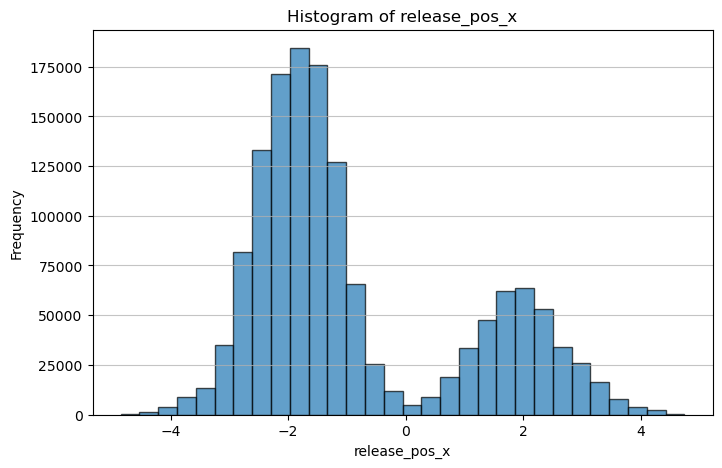

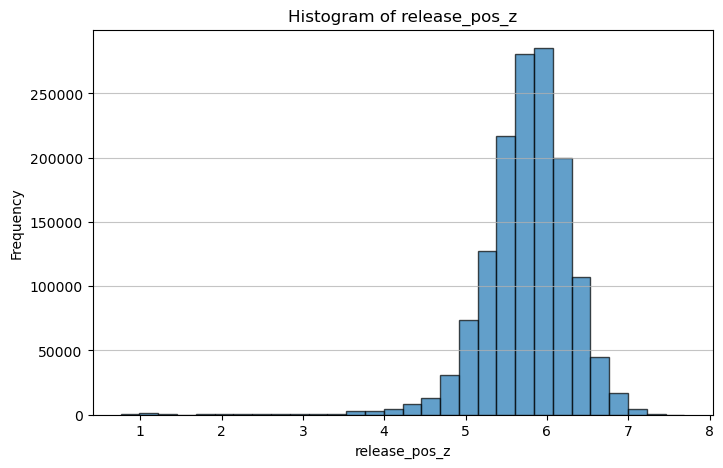

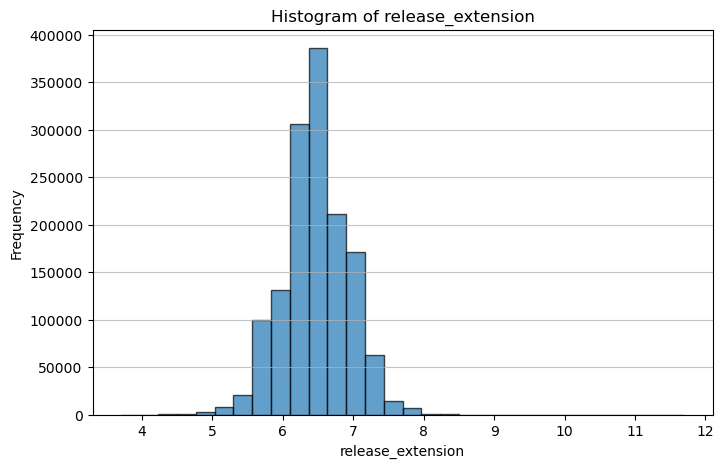

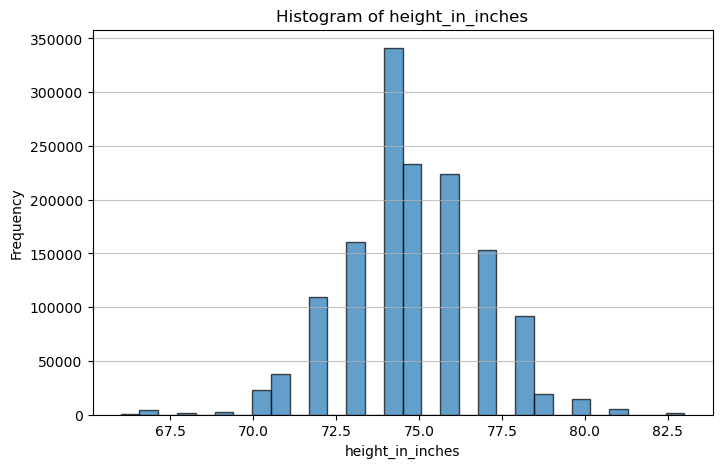

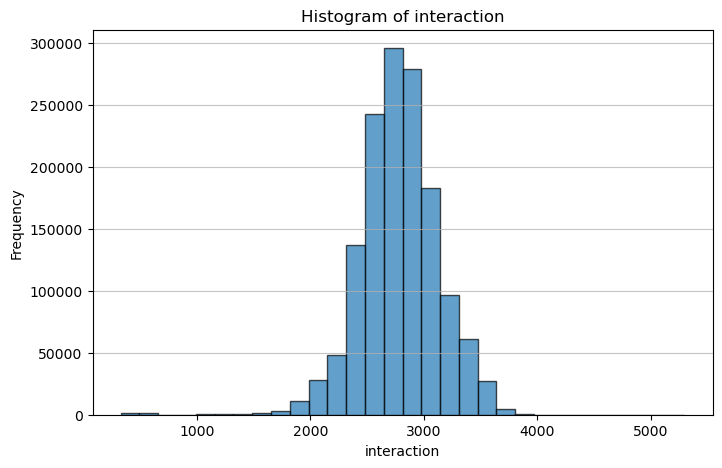

In [12]:
all['interaction'] =  all['release_pos_z'] * all['release_extension'] * all['height_in_inches']
feats = feats + ['interaction']

for feature in feats:
    plt.figure(figsize=(8, 5))
    plt.hist(all[feature], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [13]:
X = all[feats]
y = all['arm_angle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1137774, 5)
(284444, 5)
(1137774,)
(284444,)


In [14]:
all['arm_angle'].describe()

count    1422218.0
mean     38.431742
std      12.922979
min          -71.2
25%           31.2
50%           39.6
75%           46.8
max          144.0
Name: arm_angle, dtype: Float64

### Linear Regression (No Scale)

In [15]:
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

RMSE: 6.67


### Catboost

In [16]:
best_rmse = float('inf')
best_catboost_model = None

def catboost_objective(trial):
    global best_rmse, best_catboost_model

    # Define hyperparameters for optimization
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-1, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
    }

    # Select top features based on importance
    X_top_features = X[feats]

    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []

    for train_idx, val_idx in cv.split(X_top_features, y):
        cat_X_train, cat_X_val = X_top_features.iloc[train_idx], X_top_features.iloc[val_idx]
        cat_y_train, cat_y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the CatBoost model
        catboost_model = CatBoostRegressor(**params, random_seed=13, verbose=0)
        catboost_model.fit(cat_X_train, cat_y_train, eval_set=(cat_X_val, cat_y_val), early_stopping_rounds=50, verbose=0)

        cat_y_pred = catboost_model.predict(cat_X_val)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(cat_y_val, cat_y_pred))
        cv_scores.append(rmse)

    mean_rmse = np.mean(cv_scores)

    # Save the best model based on RMSE
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_catboost_model = catboost_model

    return mean_rmse

# Create and run Optuna study, optimizing to minimize RMSE
catboost_study = optuna.create_study(direction='minimize')  
catboost_study.optimize(catboost_objective, n_trials=25)

# Get the best hyperparameters from the Optuna study
best_catboost_params = catboost_study.best_params
print("Best CatBoost Params:", best_catboost_params)

[I 2025-08-21 19:09:03,458] A new study created in memory with name: no-name-dfc3e280-116a-4a3c-b6bc-f0b21e3369e6
[I 2025-08-21 19:14:56,685] Trial 0 finished with value: 5.799234388740368 and parameters: {'iterations': 1474, 'learning_rate': 0.08440447503961461, 'depth': 2, 'min_data_in_leaf': 32, 'l2_leaf_reg': 0.27395398945866906, 'border_count': 152, 'bagging_temperature': 4.06019703132044, 'random_strength': 0.19359348486127056}. Best is trial 0 with value: 5.799234388740368.
[I 2025-08-21 19:24:25,989] Trial 1 finished with value: 6.6121024275214655 and parameters: {'iterations': 1488, 'learning_rate': 0.001895577836218784, 'depth': 6, 'min_data_in_leaf': 41, 'l2_leaf_reg': 1.0186190782681854, 'border_count': 64, 'bagging_temperature': 0.5298470404333698, 'random_strength': 4.045883513359904}. Best is trial 0 with value: 5.799234388740368.
[I 2025-08-21 19:27:34,200] Trial 2 finished with value: 5.986587303274658 and parameters: {'iterations': 683, 'learning_rate': 0.078360546644

Best CatBoost Params: {'iterations': 1394, 'learning_rate': 0.06288120425745096, 'depth': 9, 'min_data_in_leaf': 38, 'l2_leaf_reg': 0.005569368586671064, 'border_count': 134, 'bagging_temperature': 0.41035918684619244, 'random_strength': 0.08646133996867059}


In [17]:
with open("best_catboost_model.pkl", "wb") as f:
    pickle.dump(best_catboost_model, f)

print("Best CatBoost model saved as 'best_catboost_model.pkl'")

Best CatBoost model saved as 'best_catboost_model.pkl'


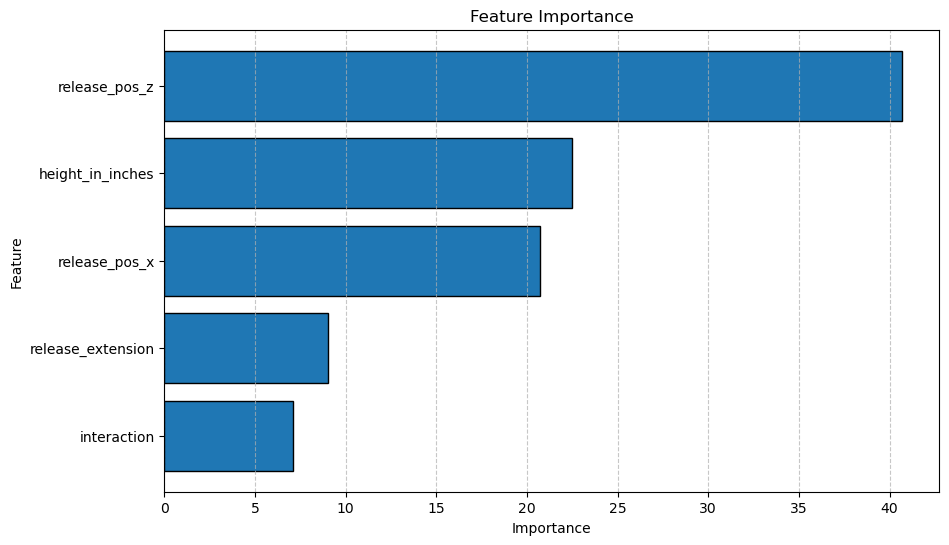

In [18]:
import seaborn as sns

importances = best_catboost_model.get_feature_importance()
feature_names = X[feats].columns  # use the same feature subset you trained on

# Put into a DataFrame for easy plotting
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot with uniform bar color
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'], edgecolor='black')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()